### Scale Models Analysis

This notebook analyzes and compares the experimental clock rates, event types, and message queue lengths of machines across different internal clock rates.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [275]:
# Helper Functions

# Iterate across trials and convert csvs to a list of dataframes
def csv_to_df(directory):
    processes = [[], [], []]
    for filename in os.listdir(directory):
        trial = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isdir(trial):
            sorted_list = sorted(os.listdir(trial))
            for i, log in enumerate(sorted_list):
                log_path = os.path.join(trial, log)
                processes[i].append(pd.read_csv(log_path))

    return processes

# Average results across dataframes
def average_dfs(processes, col_name):
    data = []
    for i in range(len(processes)):
        cols = []
        minimum = len(processes[i][0][col_name])
        trials = len(processes[i])
        for j in range(trials):
            col = processes[i][j][col_name]
            cols.append(col)
            minimum = min(minimum, len(col))
        normalized = []
        for k in range(trials):
            normalized.append(cols[k][:minimum])
        val = pd.concat([j for j in normalized]).groupby(level=0).mean()
        data.append(val)

    return data

# Helper function to format graph
def format_legend(log):
    crs = log.split('_')
    return [crs[1], crs[2], crs[3]]

# Graph results clock rate or message queue length data
def graph(directory, col_name, normal=False):
    processes = csv_to_df(directory)
    data = average_dfs(processes, col_name)
    global_time = average_dfs(processes, 'global time')

    name = col_name.split(" ")
    first = name[0].capitalize()
    second = name[1].capitalize()
    log = directory.split('/')[1].capitalize()
    crs = format_legend(log)
    if normal:
        for i in range(len(data)):
            data[i] /= int(crs[i])

    for i in range(len(data)):
        plt.plot(global_time[i], data[i], alpha=0.7)

    title = f"{log}: {first} {second} Comparison"
    plt.title(title)
    plt.xlabel('Global Time (seconds)')
    plt.ylabel(f"{first} {second}")
    plt.legend([f'Machine {i+1} (clock rate = {cr})' for i, cr in enumerate(crs)])
    plt.show()

# Display event counts for each process
def graph_events(directory):
    log = directory.split('/')[1].capitalize()
    processes = csv_to_df(directory)
    data = []
    for i in range(len(processes)):
        cols = []
        for j in range(len(processes[i])):
            col = processes[i][j]['event type'].value_counts()
            cols.append(col)
        val = pd.concat([k for k in cols]).groupby(level=0).mean()
        data.append(val)

    fig, axs = plt.subplots(len(processes), figsize=(10, 10))
    fig.tight_layout(pad=5.0)
    fig.suptitle(f'Event Comparison: {log}', size=16)
    indices = data[0].index.to_list()
    crs = format_legend(log)
    titles = [f'Machine {i+1} (clock rate = {cr})' for i, cr in enumerate(crs)]
    for i in range(len(processes)):
        axs[i].bar(indices, data[i], color=['blue', 'red', 'green'], width = 0.4)
        axs[i].set_title(titles[i])
    plt.show()

## Equivalent Clock Rates

We first graph the average event counts of 3 machines with equivalent logical clock rates of 1. Results were averaged across 10 trials. According to the probabilities in the specs, if a machine's queue is non-empty, than an internal event is triggered 70% of the time, while a send operation occurs 30% of the time.

As expected, ratios of internal events to send events for all machines was roughly 7:3. On average over 60 seconds, receive events were triggered 17-19 times, while send events occurred 13-15 times for all machines. Since there is a 10% chance that a process sends an event to both of the other processes, we expect that probability of receive events to be higher than send events when the logical clock rates are all equivalent.

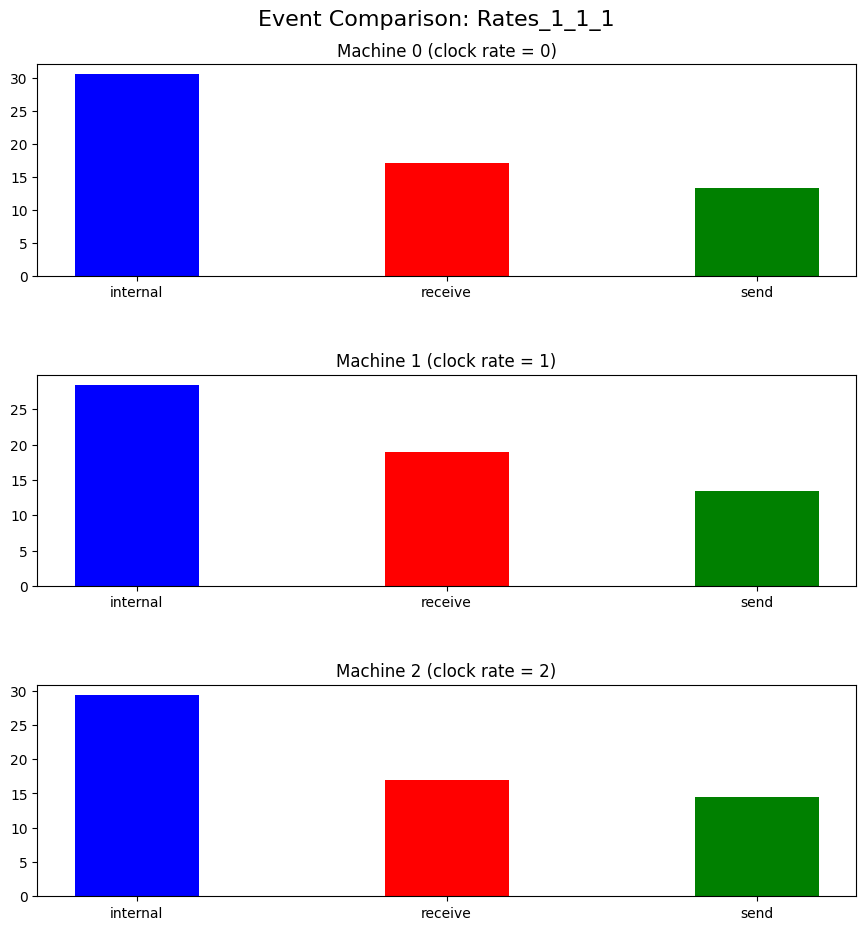

In [271]:
graph_events('logs/rates_1_1_1')

Additionally, the logical clock rates of each process was equivalent, and matched the global system time. Since each event logical clock rate of a machine was 1, the logical clock was incremented by 1 after each event, regardless of whether the process triggered an internal, send, or receive event.

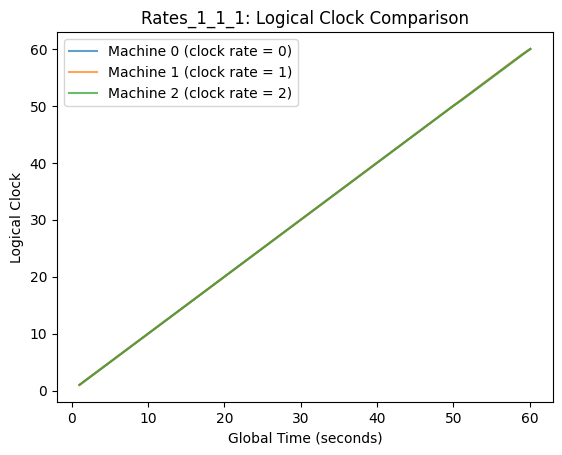

In [273]:
graph('logs/rates_1_1_1', 'logical clock', normal=False)

## Differing Clock Rates

For comparison, we graph the results of the event type counts when running the experiment with 3 machines with clock rates of 1, 3, and 6, respectively. The majority of events for Machine 1 were receive events. Since the clock rate of this machine was significantly lower than all the other machines, it's message queue was constantly non-empty, meaning that it was unable to trigger an internal or send event. For Machine 2 and Machine 3, the ratio of internal to send events was similarly close to 7:3. However, receive events made up almost 30% of the total events for Machine 2, compared to less than 5% of all events for Machine 3, which can be explained by the higher clock rate of Machine 3.

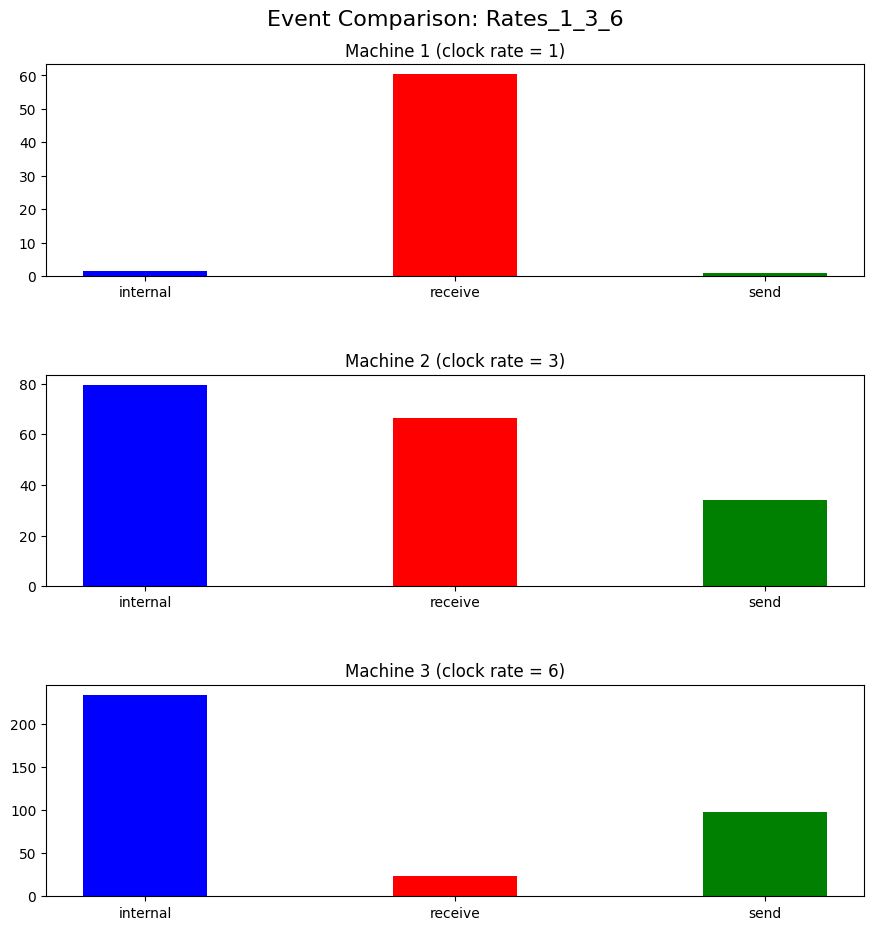

In [276]:
graph_events('logs/rates_1_3_6')

Graphing the message queue lengths and logical clock values over time for each machine tells a similar story: since the message queue of Machine 1 is always full (and increasing), it will never be able to send a message or log an internal event.

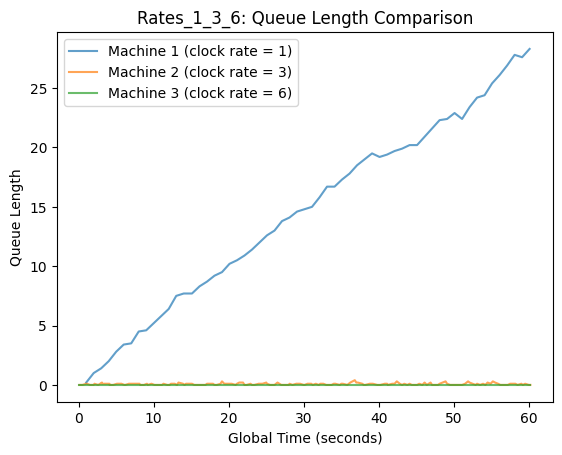

In [277]:
graph('logs/rates_1_3_6', 'queue length')

Similarly, we can see that the internal logical clock value of Machine 1 is drifting from both the true system time, and the logical clock values of Machines 2 and 3.

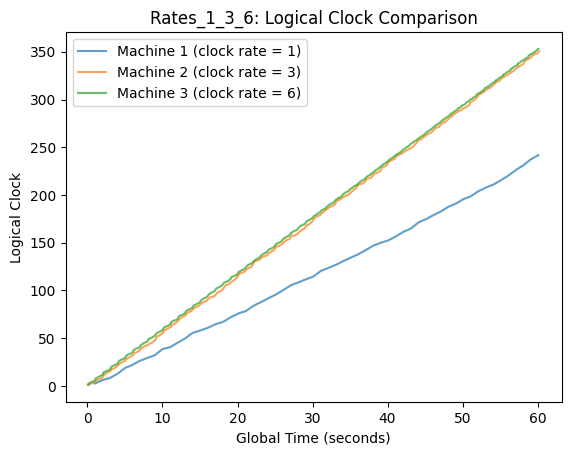

In [278]:
graph('logs/rates_1_3_6', 'logical clock')

### TODO
Explain normalized graph

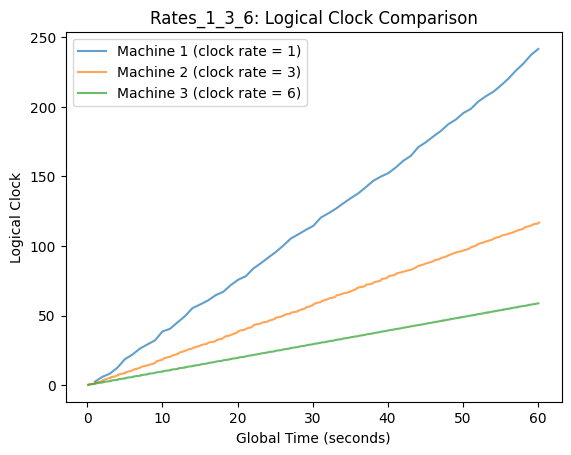

In [279]:
graph('logs/rates_1_3_6', 'logical clock', normal=True)

## TODO explain 0.25internal rate and propinc graphs